In [1]:
import h5py
import numpy as np
import pandas as pd

def read_mat_v73(mat_path: str) -> dict:
    """读取MATLAB v7.3文件 (适配NumPy 1.20+版本)"""
    data = {}
    with h5py.File(mat_path, 'r') as f:
        def visit_handler(name, obj):
            if isinstance(obj, h5py.Dataset):
                # 处理对象类型数据集
                arr = np.array(obj)
                # 类型检查改用安全方式
                if arr.dtype == np.dtype('O') or arr.dtype.type is np.object_:
                    arr = arr[0]  # 解包MATLAB容器
                data[name.split('/')[-1]] = arr
        f.visititems(visit_handler)
    return data

def mat73_to_parquet(mat_path: str, parquet_path: str) -> None:
    """转换v7.3 MAT文件到Parquet"""
    mat_data = read_mat_v73(mat_path)
    
    processed = {}
    for k, v in mat_data.items():
        # 类型检查改用dtype.kind
        if v.dtype.kind == 'O':  # 'O' 表示Python对象类型
            # 处理MATLAB cell数组
            v = np.vectorize(str)(v)  # 更高效的类型转换
        elif np.issubdtype(v.dtype, np.complexfloating):
            # 复数转为元组结构
            v = np.column_stack([v.real, v.imag])
        
        # Fortran顺序展平
        processed[k] = v.flatten(order='F') 

    # 自动对齐不同长度数组
    max_len = max(len(v) for v in processed.values())
    df = pd.DataFrame({
        k: np.pad(v, (0, max_len - len(v)), mode='empty') 
        for k, v in processed.items()
    })
    
    # 类型安全保存
    df = df.convert_dtypes() 
    df.to_parquet(parquet_path, engine='pyarrow')

# 使用示例
mat73_to_parquet("atlantic_42.mat", "atlantic_42.parquet")
mat73_to_parquet("atlantic_31.mat", "atlantic_31.parquet")
mat73_to_parquet("polar_31.mat", "polar_31.parquet")
mat73_to_parquet("polar_42.mat", "polar_42.parquet")

In [3]:
pc31 = read_mat_v73("polar_31.mat")
pc42 = read_mat_v73("polar_42.mat")
ac31 = read_mat_v73("atlantic_31.mat")
ac42 = read_mat_v73("atlantic_42.mat")
Latitudes = np.linspace(60, 90, 120)
Longitudes = np.linspace(-180, 180, 1440)
Years = np.linspace(1982, 2084, 103)
times = np.linspace(0, 19, 20)
import xarray as xr
pc31_ci = xr.DataArray(pc31['ci'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="CI")
pc31_dura_mhw = xr.DataArray(pc31['dura_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura_mhw")
pc31_dura_nan = xr.DataArray(pc31['dura_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura_nan")
pc31_mtp_mhw = xr.DataArray(pc31['mtp_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_mhw")
pc31_mtp_nan = xr.DataArray(pc31['mtp_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_nan")
pc42_ci = xr.DataArray(pc42['ci'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="CI")
pc42_dura_mhw = xr.DataArray(pc42['dura_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura_mhw")
pc42_dura_nan = xr.DataArray(pc42['dura_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura_nan")
pc42_mtp_mhw = xr.DataArray(pc42['mtp_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_mhw")
pc42_mtp_nan = xr.DataArray(pc42['mtp_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_nan")
# Years = np.linspace(1982, 2085, 104)
# ac31_ci = xr.DataArray(ac31['ci'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="CI")
# ac31_dura = xr.DataArray(ac31['dura_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura")
# ac31_mtp_mhw = xr.DataArray(ac31['mtp_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_mhw")
# ac31_mtp_nan = xr.DataArray(ac31['mtp_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_clm")
# ac42_ci = xr.DataArray(ac42['ci'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="CI")
# ac42_dura = xr.DataArray(ac42['dura_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="dura")
# ac42_mtp_mhw = xr.DataArray(ac42['mtp_mhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_mhw")
# ac42_mtp_nan = xr.DataArray(ac42['mtp_nanmhw'],dims=["time","Years","Latitude", "Longitude"],coords={"time": times, "Years": Years, "Latitude": Latitudes, "Longitude": Longitudes}, name="mtp_clm")


pc31bg=xr.Dataset({"CI":pc31_ci, "dura_mhw":pc31_dura_mhw, "dura_nan":pc31_dura_nan, "mtp_mhw":pc31_mtp_mhw, "mtp_nan":pc31_mtp_nan})
pc42bg=xr.Dataset({"CI":pc42_ci, "dura_mhw":pc42_dura_mhw, "dura_nan":pc42_dura_nan, "mtp_mhw":pc42_mtp_mhw, "mtp_nan":pc42_mtp_nan})
# ac31bg=xr.Dataset({"CI":ac31_ci, "dura":ac31_dura, "mtp_mhw":ac31_mtp_mhw, "mtp_nan":ac31_mtp_nan})
# ac42bg=xr.Dataset({"CI":ac42_ci, "dura":ac42_dura, "mtp_mhw":ac42_mtp_mhw, "mtp_nan":ac42_mtp_nan})

pc31bg.to_netcdf("pc31bg.nc")
pc42bg.to_netcdf("pc42bg.nc")
# ac31bg.to_netcdf("ac31bg.nc")
# ac42bg.to_netcdf("ac42bg.nc")

Shape: (355968000, 8)

Columns: ['ci', 'dura_mhw', 'dura_nanmhw', 'lat', 'lon', 'mtp_climate', 'mtp_mhw', 'mtp_nanmhw']

Data types:
ci             Float64
dura_mhw         Int64
dura_nanmhw      Int64
lat            Float64
lon            Float64
mtp_climate    Float64
mtp_mhw        Float64
mtp_nanmhw     Float64
dtype: object

First 5 rows:


,ci,dura_mhw,dura_nanmhw,lat,lon,mtp_climate,mtp_mhw,mtp_nanmhw
0,<NA>,<NA>,121,60.0,-180.0,<NA>,<NA>,1.207002
1,<NA>,<NA>,<NA>,60.252101,-179.749826,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>,60.504202,-179.499653,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,60.756303,-179.249479,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,61.008403,-178.999305,<NA>,<NA>,<NA>



Summary of non-NaN values per column:


,Column,Non-NaN Count,Percentage (%)
3,lat,355968000,100.000000
4,lon,355968000,100.000000
7,mtp_nanmhw,14431477,4.054150
2,dura_nanmhw,14431477,4.054150
0,ci,1518959,0.426712
1,dura_mhw,1518959,0.426712
5,mtp_climate,1518959,0.426712
6,mtp_mhw,1518959,0.426712


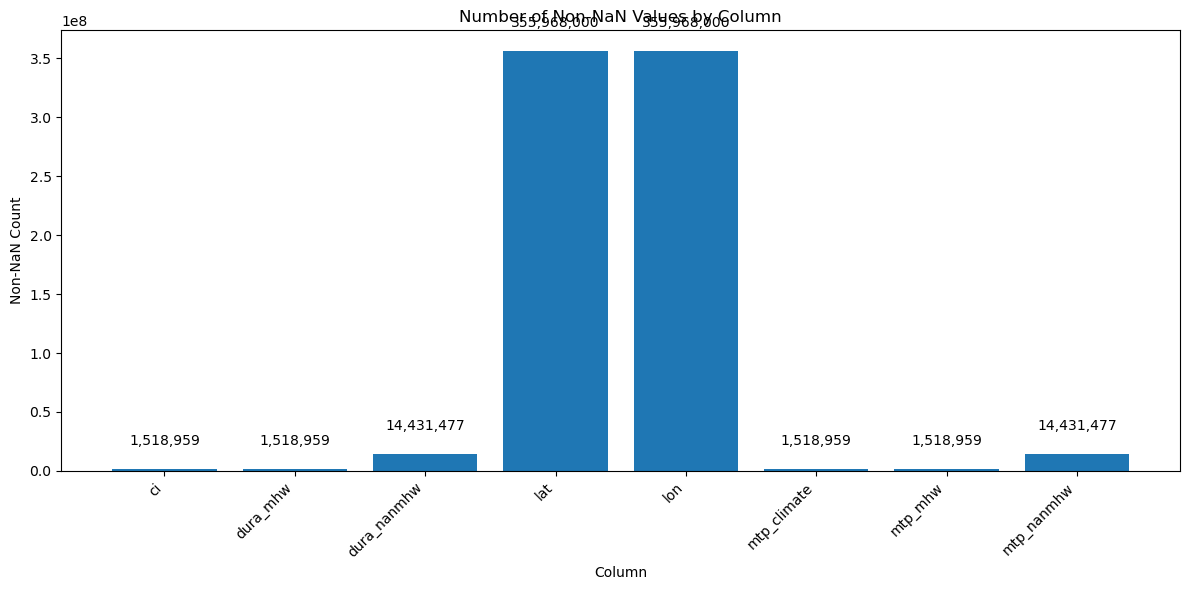

In [5]:
import pandas as pd
# Read the polar_31_pred.parquet file
polar_31_pred = pd.read_parquet("polar_31.parquet")

# Display basic information about the DataFrame
print(f"Shape: {polar_31_pred.shape}")
print("\nColumns:", polar_31_pred.columns.tolist())
print("\nData types:")
print(polar_31_pred.dtypes)

# Display the first few rows to see the data structure
print("\nFirst 5 rows:")
display(polar_31_pred.head())
# Calculate the count of non-NaN values for each column
non_nan_counts = polar_31_pred.count()

# Calculate percentage of non-NaN values
total_rows = len(polar_31_pred)
non_nan_percentages = (non_nan_counts / total_rows * 100).round(6)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Column': non_nan_counts.index,
    'Non-NaN Count': non_nan_counts.values,
    'Percentage (%)': non_nan_percentages.values
})

# Display the summary
print("\nSummary of non-NaN values per column:")
display(summary_df.sort_values('Non-NaN Count', ascending=False))

# Visualize the distribution of non-NaN values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
bars = plt.bar(summary_df['Column'], summary_df['Non-NaN Count'])
plt.xticks(rotation=45, ha='right')
plt.title('Number of Non-NaN Values by Column')
plt.xlabel('Column')
plt.ylabel('Non-NaN Count')
plt.tight_layout()

# Add count labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*max(summary_df['Non-NaN Count']),
             f'{int(height):,}', ha='center', va='bottom', rotation=0)

plt.show()